In [3]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import h5py
import cv2

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import Tensor
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Reshape, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, UpSampling2D, GlobalMaxPooling2D, Conv2DTranspose
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.python.keras.utils import layer_utils
from tensorflow.keras.utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.callbacks import CSVLogger
import keras.models
from typing import List, Tuple
from time import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [14]:
# load the mnist dataset

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

In [5]:
# we will work with only 3 classes for simplicity: 0's, 1's and 2's 

In [5]:
train_filter_0 = np.where((y_train == 0 ))
train_filter_1 = np.where((y_train == 1 ))
train_filter_2 = np.where((y_train == 2 ))

In [6]:
X_0, y_0 = x_train[train_filter_0], y_train[train_filter_0]
X_1, y_1 = x_train[train_filter_1], y_train[train_filter_1]
X_2, y_2 = x_train[train_filter_2], y_train[train_filter_2]

In [34]:
# now we take only 1000 from each class

In [7]:
X = np.concatenate((X_0[0:1000],X_1[0:1000],X_2[0:1000]), axis=0)
y = np.concatenate((y_0[0:1000],y_1[0:1000],y_2[0:1000]), axis=0)

In [42]:
# make sparse labels for classification 

In [11]:
new_y = np.zeros((y.shape[0],3))
for i in range(y.shape[0]):
    if y[i]==0:
        new_y[i,:] = np.asarray([1,0,0])
    if y[i]==1:
        new_y[i,:] = np.asarray([0,1,0])
    if y[i]==2:
        new_y[i,:] = np.asarray([0,0,1])

In [45]:
# we implement the autoencoder

In [47]:
def convolution(X: tf.Tensor, filters: List[int], kernel: Tuple[int,int], s: Tuple[int,int], padding:str, name: str) -> tf.Tensor:
    f1 = filters
    
    X = Conv2D(filters=f1, kernel_size=kernel, strides=s, padding=padding, name=name)(X)
    X = Activation('relu')(X)
    
    return X

In [48]:
def deconvolution(X: tf.Tensor, filters: List[int], kernel: Tuple[int,int], s: Tuple[int,int], padding:str, name: str) -> tf.Tensor:
    f1 = filters
    
    X = Conv2DTranspose(filters=f1, kernel_size=kernel, strides=s, padding=padding, name=name)(X)
    X = Activation('relu')(X)
    
    return X

In [49]:
def Net(input_size: Tuple[int,int,int]) -> Model:
    X_input = Input(input_size)
    
    X = convolution(X_input, filters=50, kernel=(2,2), s=(2, 2), padding='same', name='convolution_1')
    
    X = convolution(X, filters=100, kernel=(2,2), s=(2, 2), padding='same', name='convolution_2')
    
    
    X = deconvolution(X, filters=50, kernel=(2,2), s=(2, 2), padding='same', name='deconvolution_2')
    
    X = deconvolution(X, filters=1, kernel=(2,2), s=(2, 2), padding='same', name='deconvolution_3')

    # Create model
    model = Model(inputs=X_input, outputs=X, name='CAE_mnist')

    return model

In [51]:
model = Net(input_size = (28, 28, 1))

In [52]:
model.summary()

Model: "CAE_mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 convolution_1 (Conv2D)      (None, 14, 14, 50)        250       
                                                                 
 activation_4 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 convolution_2 (Conv2D)      (None, 7, 7, 100)         20100     
                                                                 
 activation_5 (Activation)   (None, 7, 7, 100)         0         
                                                                 
 deconvolution_2 (Conv2DTran  (None, 14, 14, 50)       20050     
 spose)                                                          
                                                         

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
csv_logger = CSVLogger('training_2.log')
t0 = time()
history = model.fit(X, X, batch_size=200, epochs=50, callbacks=[csv_logger])
print('Training time: ', time() - t0)

In [64]:
model.save('mnist_CAE_2.h5')

In [9]:
model = keras.models.load_model('mnist_CAE_2.h5')

In [11]:
prediction = model.predict(X)
prediction = tf.squeeze(prediction)
prediction_loss = tf.keras.losses.mse(prediction, X)
rec_err = np.sum(prediction_loss, axis=1)

94/94 [==============================] - 0s 2ms/step


In [10]:
prediction1 = model.predict(X_0)
prediction1 = tf.squeeze(prediction1)
prediction1_loss = tf.keras.losses.mse(prediction1, X_0)
rec_err1 = np.sum(prediction1_loss, axis=1)

186/186 [==============================] - 1s 2ms/step


In [11]:
prediction2 = model.predict(X_1)
prediction2 = tf.squeeze(prediction2)
prediction2_loss = tf.keras.losses.mse(prediction2, X_1)
rec_err2 = np.sum(prediction2_loss, axis=1)

211/211 [==============================] - 1s 2ms/step


In [12]:
prediction3 = model.predict(X_2)
prediction3 = tf.squeeze(prediction3)
prediction3_loss = tf.keras.losses.mse(prediction3, X_2)
rec_err3 = np.sum(prediction3_loss, axis=1)

187/187 [==============================] - 0s 2ms/step


In [14]:
import matplotlib.ticker as ticker

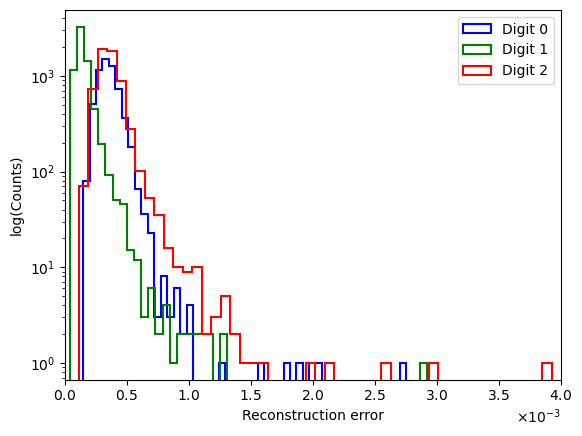

In [20]:
n1 = plt.hist(rec_err1, bins=50, label='Digit 0', color='blue', 
              histtype='step', linewidth=1.5, log='True')
n2 = plt.hist(rec_err2, bins=50, label='Digit 1', color='green', 
              histtype='step', linewidth=1.5, log='True')
n2 = plt.hist(rec_err3, bins=50, label='Digit 2', color='red', 
              histtype='step', linewidth=1.5, log='True')
plt.legend()
plt.ylabel('log(Counts)')
plt.xlabel('Reconstruction error')
plt.xlim([0,0.0040])
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.gca().xaxis.get_offset_text().set_visible(True)
plt.show()

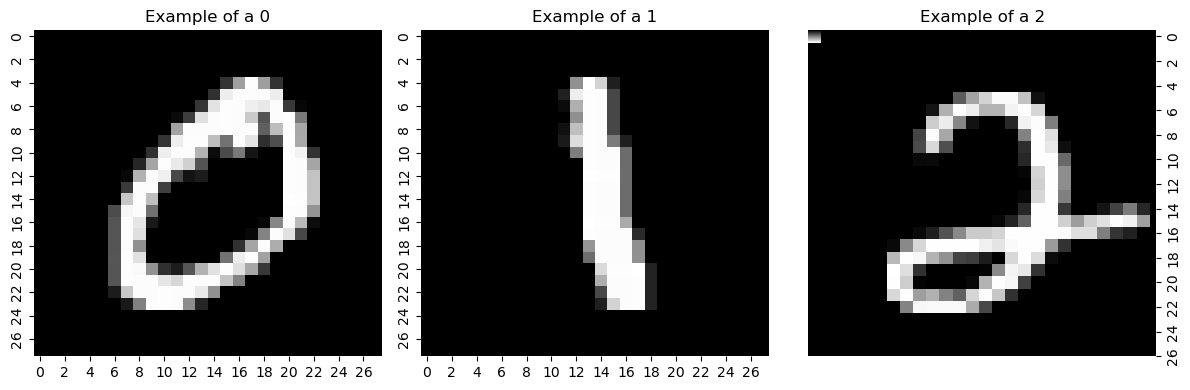

In [84]:
# Create a figure with three subplots arranged horizontally
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

vmin = 0
vmax = np.max([X[0].max(), X[1001].max(), X[2001].max()])

# Plot the first heatmap in the left subplot
ax1 = sns.heatmap(X[0], cmap='gray', cbar=False, ax=axes[0])
ax1.set_title('Example of a 0')

# Plot the second heatmap in the middle subplot
ax2 = sns.heatmap(X[1001], cmap='gray', cbar=False, ax=axes[1])
ax2.set_title('Example of a 1')

# Plot the third heatmap in the right subplot
ax3 = sns.heatmap(X[2001], cmap='gray', cbar_ax=axes[2], vmin=vmin, vmax=vmax)
ax3.set_title('Example of a 2')

# Add a shared color bar to the rightmost subplot
cbar = ax3.collections[0].colorbar

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# visualize embedded space

In [18]:
feature_model = Model(inputs=model.input, outputs=model.get_layer(name='convolution_2').output)
features = feature_model.predict(X)
print('feature shape=', features.shape)

94/94 [==============================] - 2s 15ms/step
feature shape= (3000, 7, 7, 100)


In [19]:
features1 = np.reshape(features, newshape=(features.shape[0], -1))

In [20]:
tSNE = TSNE(n_components=2, learning_rate='auto')
X_tsne = tSNE.fit_transform(features1)

In [23]:
g = h5py.File('new_mnist_y', 'r')
y_new = g['y'][:]

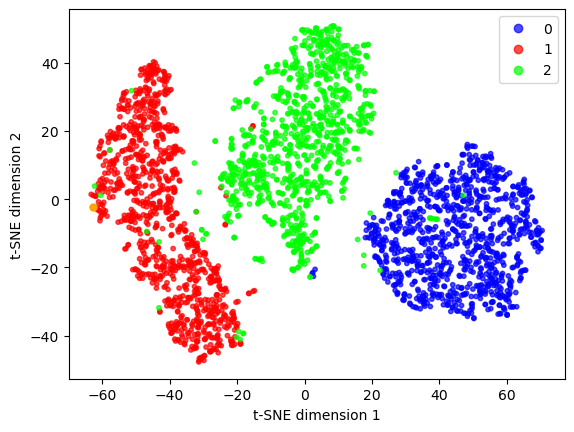

In [126]:
plot = plt.scatter(y_new[:,0], y_new[:,1], s=10, c=y, alpha=0.7, cmap='brg')
plt.scatter(y_new[142,0], y_new[142,1], s=25, c='orange', alpha=1)
plt.legend(handles=plot.legend_elements()[0], 
           labels=['0', '1', '2'])
plt.ylabel('t-SNE dimension 2')
plt.xlabel('t-SNE dimension 1')
#plt.title('Embedded space of digits')
plt.show()

In [23]:
mnist_model = keras.models.load_model('mnist_CAE_2.h5')

In [15]:
def generate_saliency_maps(model, images):
    # Convert images to tensors
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    images = tf.expand_dims(images, axis=0)
    images = tf.cast(images, tf.float32)

    # Keep track of gradients
    with tf.GradientTape() as tape:
        tape.watch(images)
        reconstructed_images = model(images)

    # Compute gradients with respect to the input images
    gradients = tape.gradient(reconstructed_images, images)

    # Compute the saliency maps as the absolute mean of the gradients
    saliency_maps = tf.reduce_mean(tf.abs(gradients), axis=0)

    return saliency_maps

In [71]:
n = 2050

In [72]:
saliency_map = generate_saliency_maps(mnist_model, X[n])

In [73]:
saliency_map = (saliency_map-np.min(saliency_map))/(np.max(saliency_map)-np.min(saliency_map))

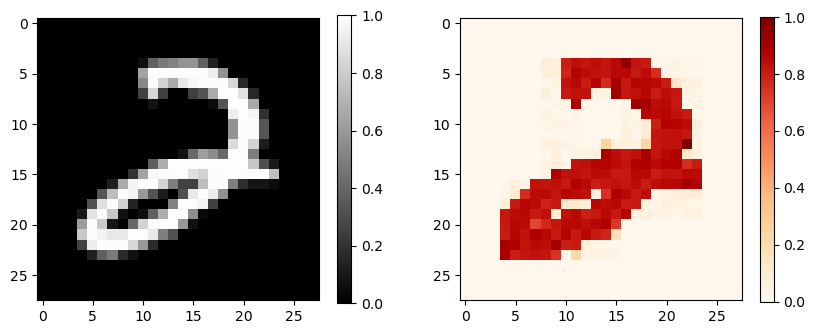

In [81]:
fig, axs = plt.subplots(figsize=(10,10), ncols=2)
pos = axs[0].imshow(X[n], cmap='gray', label='Original Image')
fig.colorbar(pos, ax=axs[0], shrink=0.374)
pos2 = axs[1].imshow(saliency_map, cmap='OrRd', label='Saliency Map')
fig.colorbar(pos2, ax=axs[1], shrink=0.37)
plt.show()